In [1]:
%load_ext autoreload
%autoreload 2
from geolifeclef.utils import get_spark

spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 04:42:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/11 04:42:13 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [53]:
metadata = spark.read.parquet(
    "gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_clean/v1"
)
metadata.printSchema()
metadata.show()

root
 |-- dataset: string (nullable = true)
 |-- surveyId: integer (nullable = true)
 |-- lat_proj: double (nullable = true)
 |-- lon_proj: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- geoUncertaintyInM: double (nullable = true)
 |-- speciesId: double (nullable = true)

+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
| dataset|surveyId|           lat_proj|            lon_proj|      lat|      lon|year|geoUncertaintyInM|speciesId|
+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+---------+
|      po|  599428|-3546710.1309880773|1.5869697752944473E7| 41.35689|-3.323538|2020|              2.0|   3932.0|
|pa_train| 3707965|-1614858.9153893404| 1.690952987363603E7| 57.04466|  9.05137|2017|             10.0|   7739.0|
|pa_train|  331966|-1882413.1908692368|1.5621125512619067E7| 46.323

In [3]:
from pyspark.sql import functions as F
import numpy as np

species_count = metadata.groupBy("speciesId").count()
species_count.orderBy(species_count["count"].desc()).show()
print(species_count.count())

+---------+-----+
|speciesId|count|
+---------+-----+
|    540.0|27928|
|   4397.0|25013|
|    254.0|23336|
|   2885.0|23270|
|   4499.0|21036|
|  10317.0|19883|
|  11140.0|19393|
|   1964.0|19334|
|  10600.0|19311|
|  10073.0|19242|
|  10255.0|18643|
|   9816.0|18360|
|   8208.0|17022|
|  11195.0|16968|
|   6310.0|16826|
|   6962.0|16659|
|   6079.0|16398|
|    963.0|15771|
|   8818.0|15566|
|   6643.0|15508|
+---------+-----+
only showing top 20 rows



10359


In [4]:
species_count["count"]

Column<'count'>

In [66]:
os.cpu_count()

4

In [5]:
max_count = species_count.agg(F.max("count").alias("Max"))
min_count = species_count.agg(F.min("count").alias("Min"))

max_value = max_count.first().Max
min_value = min_count.first().Min

print(max_count.first().Max)
print(min_count.first().Min)

min_row = species_count.filter(species_count["count"] == max_count.first().Max)
max_row = species_count.filter(species_count["count"] == min_count.first().Min)

# Show the results
min_row.show()
max_row.show()

27928


1


+---------+-----+
|speciesId|count|
+---------+-----+
|    540.0|27928|
+---------+-----+



+---------+-----+
|speciesId|count|
+---------+-----+
|   9753.0|    1|
|  10681.0|    1|
|  10625.0|    1|
|   5136.0|    1|
|   3029.0|    1|
|   9797.0|    1|
|    170.0|    1|
|     70.0|    1|
|   3448.0|    1|
|   7784.0|    1|
|  10796.0|    1|
|   8165.0|    1|
|   8144.0|    1|
|    925.0|    1|
|   3321.0|    1|
|   5738.0|    1|
|   1940.0|    1|
|   9762.0|    1|
|   1551.0|    1|
|   9650.0|    1|
+---------+-----+
only showing top 20 rows



In [6]:
bin_edges = np.linspace(min_value, max_value, 14).tolist()
bin_edges

[1.0,
 2149.230769230769,
 4297.461538461538,
 6445.692307692307,
 8593.923076923076,
 10742.153846153846,
 12890.384615384613,
 15038.615384615383,
 17186.846153846152,
 19335.076923076922,
 21483.30769230769,
 23631.53846153846,
 25779.769230769227,
 27928.0]

In [7]:
freq = species_count.select("count").rdd.flatMap(lambda x: x)

In [8]:
histogram_bins, histogram_counts = freq.histogram(bin_edges)

print("Bin edges: ", histogram_bins)
print("Counts: ", histogram_counts)

Bin edges:  [1.0, 2149.230769230769, 4297.461538461538, 6445.692307692307, 8593.923076923076, 10742.153846153846, 12890.384615384613, 15038.615384615383, 17186.846153846152, 19335.076923076922, 21483.30769230769, 23631.53846153846, 25779.769230769227, 27928.0]
Counts:  [9388, 371, 403, 100, 43, 19, 14, 9, 5, 3, 2, 1, 1]


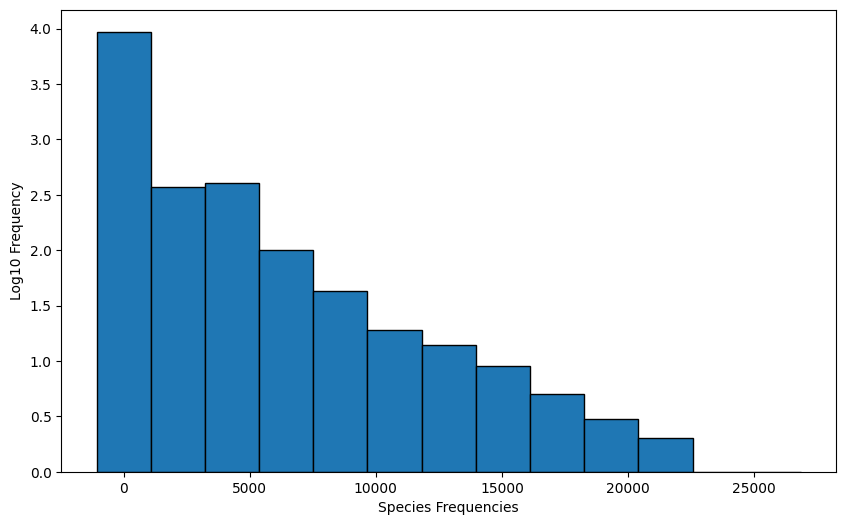

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.bar(
    histogram_bins[:-1],
    [np.log10(counts) for counts in histogram_counts],
    width=np.diff(histogram_bins),
    edgecolor="black",
)
plt.xlabel("Species Frequencies")
plt.ylabel("Log10 Frequency")
plt.show()

In [42]:
log_base = 2
log_df = species_count.withColumn(
    f"log_bin_{log_base}", F.floor(F.log10(F.col("count")) / F.log10(F.lit(log_base)))
)
log_df.show()

+---------+-----+---------+
|speciesId|count|log_bin_2|
+---------+-----+---------+
|  10024.0| 9167|       13|
|   4142.0| 3826|       11|
|  11028.0| 1971|       10|
|    305.0| 4815|       12|
|   7115.0| 2292|       11|
|   3597.0|  491|        8|
|   1051.0| 5922|       12|
|   9923.0|  417|        8|
|   1761.0| 5835|       12|
|   6067.0| 2540|       11|
|   6433.0|   61|        5|
|   7171.0|  659|        9|
|    299.0|  759|        9|
|   7782.0|  289|        8|
|    558.0|  148|        7|
|  10930.0|   49|        5|
|    769.0|   18|        4|
|   6653.0|  157|        7|
|   6765.0|  213|        7|
|    596.0|   55|        5|
+---------+-----+---------+
only showing top 20 rows



In [43]:
metadata_count = metadata.join(log_df, on="speciesId", how="inner")
metadata_count.show()

+---------+--------+--------+-------------------+--------------------+---------+--------+----+-----------------+-----+---------+
|speciesId| dataset|surveyId|           lat_proj|            lon_proj|      lat|     lon|year|geoUncertaintyInM|count|log_bin_2|
+---------+--------+--------+-------------------+--------------------+---------+--------+----+-----------------+-----+---------+
|  10024.0|pa_train| 3493784|-1636995.1215402242|  1.63134377355146E7| 52.50813|13.00049|2017|              5.0| 9167|       13|
|   4142.0|pa_train|  417724|-2202573.6671659616|1.6400912437895492E7|50.820965|5.776851|2018|              3.0| 3826|       11|
|  11028.0|      po|  456430| -2537613.019963995| 1.672225578143443E7| 51.38481|-0.17016|2020|             65.0| 1971|       10|
|    305.0|      po|  158517| -2114474.337095449|1.6282125802812638E7| 50.36297|7.557454|2019|             64.0| 4815|       12|
|    305.0|      po|  431235|-1740801.1506414176|1.6212278511304881E7| 51.34674|12.34443|2020|   

In [44]:
metadata_count.filter(metadata_count.speciesId == 10024).show()

+---------+--------+--------+-------------------+--------------------+---------+--------+----+-----------------+-----+---------+
|speciesId| dataset|surveyId|           lat_proj|            lon_proj|      lat|     lon|year|geoUncertaintyInM|count|log_bin_2|
+---------+--------+--------+-------------------+--------------------+---------+--------+----+-----------------+-----+---------+
|  10024.0|pa_train| 3493784|-1636995.1215402242|  1.63134377355146E7| 52.50813|13.00049|2017|              5.0| 9167|       13|
|  10024.0|      po|   59557|-1594713.3380299946|1.6878330236158393E7| 56.90557|9.571581|2021|              3.0| 9167|       13|
|  10024.0|      po|  545236|-1680000.0019777962| 1.675711155307765E7| 55.64893|9.396588|2019|              3.0| 9167|       13|
|  10024.0|pa_train| 1727576| -2101717.142513414|1.6516045479598204E7|52.071601|6.086648|2017|              3.0| 9167|       13|
|  10024.0|pa_train| 1868866|-1504141.4227291741|  1.66830569039452E7| 55.83221|12.26147|2018|   

In [61]:
!gsutil rm -r gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/*

Removing gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/#1715406901939546...
Removing gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/_SUCCESS#1715406902119203...
Removing gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=0/part-00000-258bcaab-9d0e-4aab-b175-1347e636b05c.c000.snappy.parquet#1715406888605441...
Removing gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=0/part-00001-258bcaab-9d0e-4aab-b175-1347e636b05c.c000.snappy.parquet#1715406891348213...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=0/part-00002-258bcaab-9d0e-4aab-b175-1347e636b05c.c0

In [49]:
log_base_name = f"log_bin_{log_base}"
output_path = "gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split"

metadata_count.write.partitionBy(log_base_name).format("parquet").save(output_path)

In [62]:
!gsutil ls gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split

gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/_SUCCESS
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=0/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=1/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=10/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=11/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=12/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=13/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=14/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=2/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=3/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=4/
gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=5/
gs://dsgt-clef-geolifeclef-2024/data

In [63]:
import os
from google.cloud import storage


def list_blobs_with_prefix(bucket_name, prefix, delimiter="/"):
    """List all blobs in a bucket that begin with the prefix."""
    storage_client = storage.Client()

    # Ensure prefix ends with a delimiter if we're trying to list "directories"
    if not prefix.endswith(delimiter):
        prefix += delimiter

    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    for _ in blobs:
        pass

    prefixes = []
    if hasattr(blobs, "prefixes"):
        for prefix in blobs.prefixes:
            if prefix.endswith(delimiter):
                prefix = prefix[:-1]
            prefixes.append(os.path.join("gs://" + bucket_name, prefix))
    else:
        print("No subdirectories found.")

    return prefixes


# Example usage
bucket_name = "dsgt-clef-geolifeclef-2024"
prefix = "data/processed/metadata_split"
delimiter = "/"  # This helps to list "directories"

directories = list_blobs_with_prefix(bucket_name, prefix, delimiter)
directories

['gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=9',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=12',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=1',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=13',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=14',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=2',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=4',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=6',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=3',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=0',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=7',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_split/log_bin_2=8',
 'gs://dsgt-clef-geolifeclef-2024/data/processed/metadata_spl

In [65]:
test_df = spark.read.parquet(directories[1])
test_df.show()

+---------+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+-----+
|speciesId| dataset|surveyId|           lat_proj|            lon_proj|      lat|      lon|year|geoUncertaintyInM|count|
+---------+--------+--------+-------------------+--------------------+---------+---------+----+-----------------+-----+
|   1051.0|pa_train| 3412695|-2184955.7611585953|1.6529686403457548E7|51.791987| 5.052532|2018|              3.0| 5922|
|   1761.0|      po|  413828|-2772968.6334859626|1.6643487800882865E7| 49.71669|-1.858366|2020|             10.0| 5835|
|   1051.0|pa_train| 2988921|-1622389.4078049771|1.5032506910059154E7| 42.44147| 19.24652|2020|             10.0| 5922|
|   1051.0|pa_train|  949197|-2209196.5968492534|1.6592893719301667E7|52.114129| 4.314883|2019|              3.0| 5922|
|   1761.0|      po|     892|-2375170.7526728497|1.6564332281930208E7| 51.14661|  2.73312|2020|             30.0| 5835|
|   1761.0|pa_train| 1945746|-1700593.80

In [14]:
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier

feature_cols = ["lat", "lon"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_df = assembler.transform(metadata_count)

xgb_classifier = XgboostClassifier(inputCols=feature_cols, outputCol="speciesId")

models = {}

for group in groups:
    group_bin = group[f"log_bin {log_base}"]
    group_data = train_df.filter(F.col(log_col_name) == group_bin)

    model = xgb_classifier.fit(group_data)
    models[group_bin] = model

ModuleNotFoundError: No module named 'sparkdl'